# Digit Image Classification Through SVD
---

The goal of this exercise is the classification of hand written digit images by utilizng SVD.

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import openpyxl as op
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set()
warnings.simplefilter("ignore")

## Data Preprocessing
---

Our dataset consists of handwritten digit images splitted into training and test subsets with 1707 and 2007 instances, respectively.

In [2]:
# load traing
x_train = pd.read_excel('./data.xlsx', sheet_name='azip', header=None).T
y_train = pd.read_excel('./data.xlsx', sheet_name='dzip', header=None).T

# load testing
x_test = pd.read_excel('./data.xlsx', sheet_name='testzip', header=None).T
y_test = pd.read_excel('./data.xlsx', sheet_name='dtest', header=None).T

We'll implement the `display_image` function for visualizing a digit image given its 1-dimensional format:

In [3]:
def display_image(x: pd.core.series.Series) -> None:
    
    """
    A function that accepts an image in pandas Series form and displays it.
    
    PARAMETERS
        @ x: pandas Series object corresponding to image array

    RETURNS
        None, displays image through matplotlib
    """
    
    image_list = x.tolist() # Series to list
    image_2d = np.reshape(image_list, (16, 16)) # transform 1x256 to 16x16
    plt.imshow(image_2d, cmap='gray') # display

Before moving on, it is worth exploring the centroids of the digits in the training set:

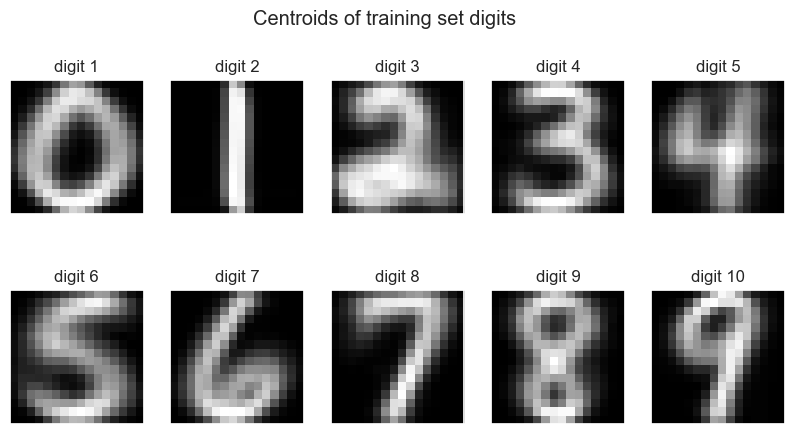

In [4]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Centroids of training set digits')

for i in range(1, 11):
    ax = fig.add_subplot(2, 5, i)
    ax.set_xticks([]) # remove x-ticks
    ax.set_yticks([]) # remove y-ticks
    ax.set_title('digit {}'.format(i))
    display_image(x_train.loc[y_train[0] == i-1].mean())

Taking a closer look at the above results we get the impression that the majority (if not all) of the digits are well written. This indicates that the clusters of digits are well separated.

## 2-stage Classification Algorithm
---

Given a matrix A, we know its SVD factorization:

$$
    A = U Σ V^T = \sum \limits _{i=1} ^m σ_i u_i v_i^Τ
$$

Expanding on this formula, we assume that an image can be accurately approximated by its first singular components. Given that, we will calculate the first couple singular images for every cluster of digits aiming to use that information to classify seemingly unknown inputs. 

The proposed algorithm consists of **2 stages**: 

- During the first phase we will compare the unknown digit to the **first singular vector** of each class. If the residual for one class is significantly smaller than for others we will classify the image as that class
- If no significant difference occurs, the algorithm proceeds to the second phase, where the images is compared against a **fixed basis (5) of singular vectors** for every class. The class with the smaller residual vector is deemed as the most dominant one. The respective least squares problem is formulated as follows:

$$
    min || z - \sum \limits _{i=1} ^k u_i ||_2
$$

where the unknown digit is denoted with *z*. 

We will start by calculating the SVD matrices of basis 1 and 5 for every digit cluster 0-9. We will store the resulting matrices in a dictionary:

In [5]:
acc = {}
for digit in range(10):
    # calculate svd
    u, s, vh = np.linalg.svd(np.reshape(
        x_train.loc[y_train[0] == digit].mean().tolist(),
        (16, 16)), 
        full_matrices=True
    )
    sum_singular = 0
    first_singular = 0
    for comp in range(5):
        if comp == 0:
            # reconstruct basis - 1
            first_singular = ( u.T[comp] * s[comp] ).reshape(16, 1) @ \
                             ( vh[comp].reshape(1, 16) )
        else:
            # reconstruct basis, add to previous singular components
            # (add first singular at the end of the process)
            sum_singular += ( u.T[comp] * s[comp] ).reshape(16, 1) @ \
                            ( vh[comp].reshape(1, 16) )
    # return a tuple with (basis-1, basis-5)
    acc[digit] = (first_singular, first_singular + sum_singular)

We will now move on with the proposed algorirthm:

We clarify that the purpose of the first phase it to explore in what extend we can avoid unnecessary calculations for the classification of a digit. The criterion we choose for deciding whether the basis-1 residual for a given class is significantly smaller than other classes is the following:

$$
    \frac { | ( residual_{a} - \sum \limits _{i=0} ^9 residual_{i} | } { \sum \limits _{i=0} ^9 residual_{i} } >= 0.65
$$

The threshold described is directly connected to the task at hand. It should be small enough to avoid as much calculations as possible and large enough to classify a digit infallibly. We went for a percentage difference of **70%** after checking a variety of thresholds on the **training set**.

In [6]:
# accumulators for base-1 and base-5 predictions
first_basis, fifth_basis = [], []

for i in range(x_test.to_numpy().shape[0]):
    
    # flag in case base-1 solution is found
    flag = 0
    
    # prepare image-to-classify
    curr = np.reshape(x_test.iloc[i].to_numpy(), (16, 16))
    
    # calculate norm-2 of the residual for every base-1 class
    lst = []
    for digit in range(10):
        diff = curr - acc[digit][0] # basis-1
        norm = np.linalg.norm(diff, 2) # norm-2
        lst.append(norm)
        
    # 1-stage: decide if basis-1 is sufficient for classification
    mean_lst_threshold = ( sum(lst) / len(lst) ) 
    for j in range(len(lst)):
        if (abs(lst[j]-mean_lst_threshold)) / mean_lst_threshold >= 0.70:
            first_basis.append((i, j, y_test.iloc[i][0]))
    
    # set found-solution-flag
    if first_basis:
        if first_basis[-1][0] == i:
            flag = 1
            
    # stage-2: predict according to minimum norm-2 residual
    if flag == 1:
        continue
        
    # calculate norm-2 of the residual for every base-5 class
    else:
        lst = []
        for digit in range(10):
            diff = curr - acc[digit][1] # basis-5
            norm = np.linalg.norm(diff, 2) # norm-2
            lst.append(norm)
        pred = lst.index(min(lst))
        fifth_basis.append((pred, y_test.iloc[i][0]))

After calculating some key metrics for our predictions we get:

In [7]:
print('Stage One:')
print('==========')
print('Accuracy: {:.2f}%'.format(
    len([x for x in first_basis if x[1]==x[2]]) / len(first_basis) * 100))
print('Number of predictions: {}'.format(len(first_basis)))
print('Percentage of test set: {:.2f}%'.format((
    len(first_basis) / len(x_test)) * 100))
print('Variation of digits: {}'.format(
    set([x[1] for x in first_basis])))

Stage One:
Accuracy: 100.00%
Number of predictions: 83
Percentage of test set: 4.14%
Variation of digits: {1}


In [8]:
print('Stage Two:')
print('==========')
print('Accuracy: {:.2f}%'.format(
    len([x for x in fifth_basis if x[0]==x[1]]) / len(fifth_basis) * 100))
print('Number of predictions: {}'.format(len(fifth_basis)))
print('Percentage of test set: {:.2f}%'.format((
    len(fifth_basis) / len(x_test)) * 100))
print('Variation of digits: {}'.format(
    set([x[1] for x in fifth_basis])))

Stage Two:
Accuracy: 76.51%
Number of predictions: 1924
Percentage of test set: 95.86%
Variation of digits: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


We note the following points:

- Stage one can avoid unnecessary calculations for roughly the **4%** of our test dataset, leading to **100%** accuracy
- Stage one was efficient only for images corresponding to digit **1**
- Stage two achieves roughly **77%** accuracy for the rest **96%** of the test subset


## Exploration of Different Number of Base Vectors and Accuracy
---

At this section we will explore how different number of basis vectors affect the accuracy of classification for each different class. We will start with the re-population of our dictionary of different basis vectors:

In [9]:
acc = {}
for digit in range(10):
    # calculate svd
    u, s, vh = np.linalg.svd(
        np.reshape(x_train.loc[y_train[0] == digit].mean().tolist(), 
        (16, 16)), 
        full_matrices=True
    )
    sum_singular = 0
    first_singular = 0
    for comp in range(9):
        if comp == 0:
            # reconstruct basis - 1
            first_singular = ( u.T[comp] * s[comp] ).reshape(16, 1) @ \
                             ( vh[comp].reshape(1, 16) )
            acc[(digit, 1)] = first_singular
        else:
            # reconstruct basis, add to previous singular components
            # (add first singular at the end of the process)
            sum_singular += ( ( u.T[comp] * s[comp] ).reshape(16, 1) @ \
                              ( vh[comp].reshape(1, 16) ) )
            acc[(digit, comp+1)] = first_singular + sum_singular

We move on to the prediction phase on the test set:

In [10]:
final = []
for i in range(x_test.to_numpy().shape[0]):
    
    # prepare image-to-classify
    curr = np.reshape(x_test.iloc[i].to_numpy(), (16, 16))
    
    # calculate norm-2 of the residual for every base-x class
    for base in range(1, 10):
        lst = []
        for digit in range(10):
            diff = curr - acc[(digit, base)]
            norm = np.linalg.norm(diff, 2) # norm-2
            lst.append(norm)
        pred = lst.index(min(lst))
        final.append((i, base, pred, y_test.iloc[i][0]))
        
# calculate accuracy
results = []
for digit in range(10):
    # select digit
    curr = [x for x in final if x[3] == digit]
    for base in range(1, 10):
        # select base
        curr_b = [x for x in curr if x[1] == base]
        # calculate accuracy
        res = (len([x for x in curr_b if x[2]==x[3]]) / len(curr_b)) * 100
        results.append((digit, base, round(res, 2)))

Visualing the results we get:

In [11]:
# format results to dataframe
df = pd.DataFrame.from_dict(
    {
        'digit': [x[0] for x in results],
        'base': [x[1] for x in results],
        'accuracy': [x[2] for x in results],  
    }
)

# styling
styles = [
    dict(
        selector="caption",
        props=[
            ("text-align", "center"),
            ("font-size", "130%"),
            ("color", 'black')
        ]
    )
]

df = df.pivot(index='base', columns='digit', values='accuracy')
df['avg'] = df.mean(numeric_only=True, axis=1)
df.style.highlight_max(color='lightgreen', axis=0).format(precision=2). \
         set_caption("Classification accuracy per digit per basis"). \
         set_table_styles(styles)

digit,0,1,2,3,4,5,6,7,8,9,avg
base,,,,,,,,,,,
1,51.53,92.05,45.45,21.08,53.50,22.50,35.88,58.50,42.77,42.94,46.62
2,78.55,95.08,60.61,65.06,51.50,49.38,72.35,78.91,63.86,68.93,68.42
3,82.45,95.45,64.65,68.67,68.50,63.75,75.88,86.39,66.27,75.71,74.77
4,82.73,95.45,66.16,71.08,68.00,67.50,78.82,80.95,68.67,79.66,75.90
5,82.17,95.45,66.67,71.69,69.50,65.62,80.00,82.99,69.88,78.53,76.25
6,81.89,95.45,67.17,71.69,69.50,66.25,79.41,82.99,69.28,78.53,76.22
7,81.89,95.45,67.17,71.69,69.50,66.25,79.41,82.99,69.88,77.97,76.22
8,81.89,95.45,67.17,71.69,69.50,66.25,79.41,82.99,69.88,78.53,76.28
9,81.89,95.45,67.17,71.69,69.50,66.25,79.41,82.99,69.88,78.53,76.28


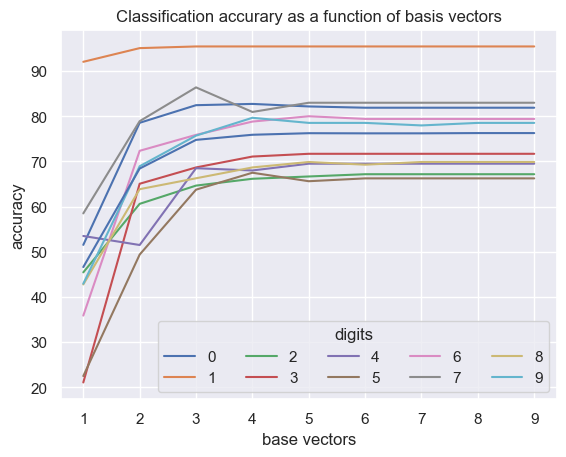

In [12]:
# plot accuracy against base
plt.plot(df)
plt.ylabel('accuracy')
plt.xlabel('base vectors')
plt.title('Classification accurary as a function of basis vectors')
plt.legend('0123456789', title='digits', ncol=5, loc='lower right');

Summarizing the above, we conclude that a different number of signular vectors is needed for each class to get classified optimally. 

**Digits 1** and **7** require the least amount of singular components **(3)** to achieve their best accuracy, while **digit 2** requires the most singular components **(6)**, given our dataset. It is also worth noting the accuracy drop that occurs with the addition of singular components, indicating the addition of noise.

For exploratory purposes we will visualize the first 3 basis vectors for each class:

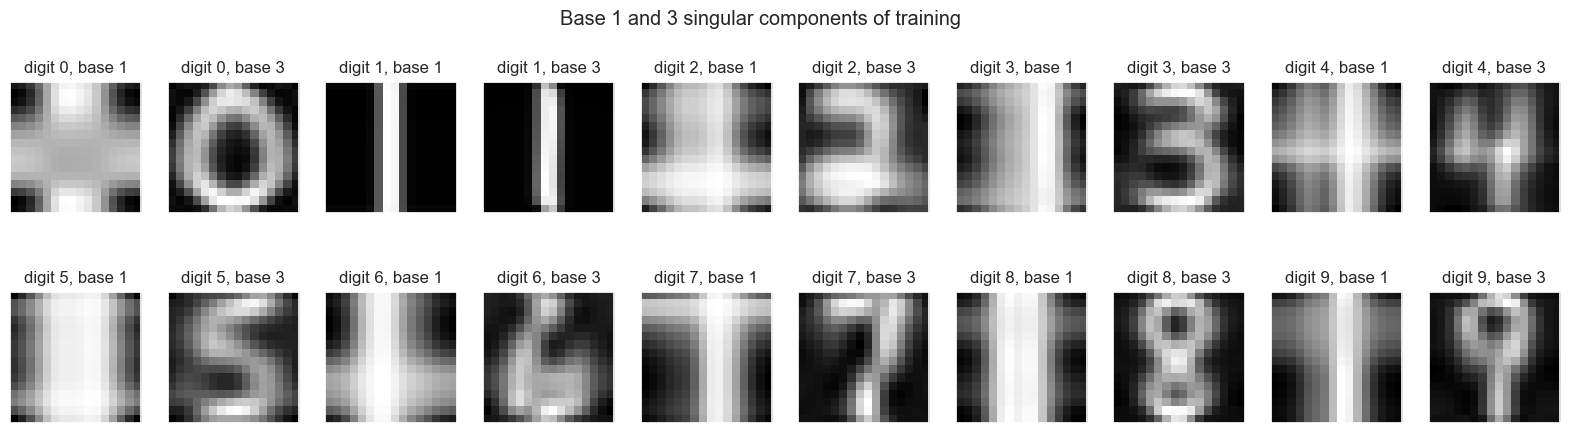

In [13]:
# plot
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Base 1 and 3 singular components of training')

s = 1
for i in range(10):
    for j in range(1, 4, 2):
        ax = fig.add_subplot(2, 10, s)
        ax.set_title('digit {}, base {}'.format(i, j))
        ax.set_xticks([]) # remove x-ticks
        ax.set_yticks([]) # remove y-ticks
        display_image(acc[i, j])
        s += 1

The above images further confirm the acucracy we previously produced. We notice that the base 3 vectors accurately describe digits **1** and **7**, while producing a rather vague picture for digits **2** and **6**. It is also worth noticing that **4**, **9** and **5**, **8** appear to be similar, indicating that more singular components are required for their successful classification.

It is also worthing exploring the different writing styles that populate our dataset. Hence, we visualize a couple of missclassified digits:

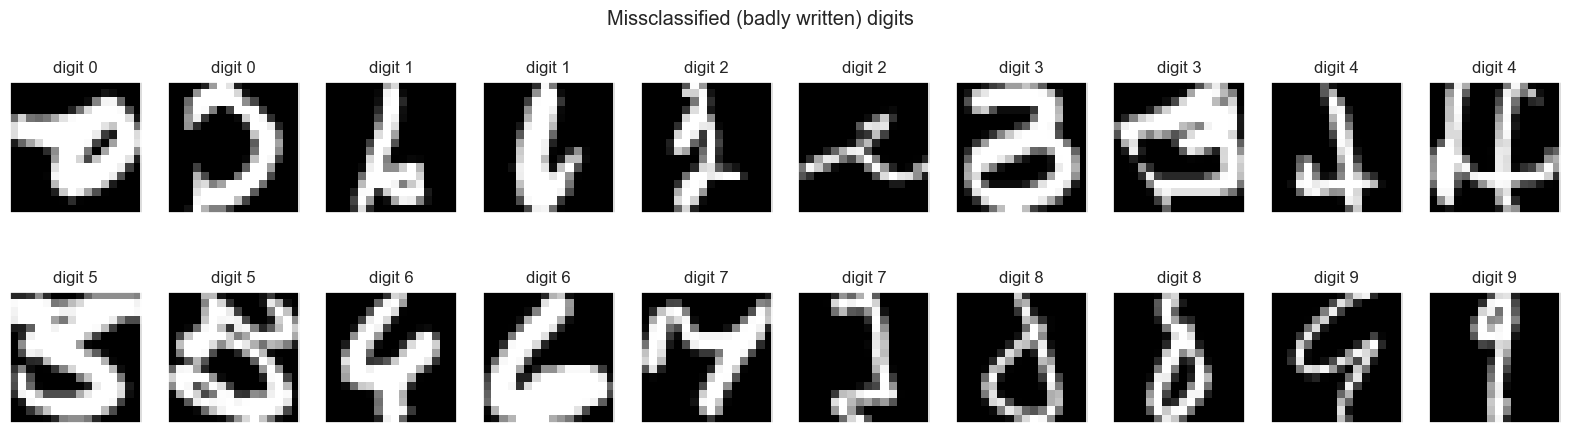

In [14]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Missclassified (badly written) digits')

# randomly pick 2 pairs of misclassified images
miss_img = []
miss = [x for x in final if x[2] != x[3]]
for digit in range(10):
    for i in range(2):
        r = random.choice(miss)
        while r[3] != digit:
            r = random.choice(miss)
        miss_img.append(r)

# picking of badly written digits
badly_written = [494, 1006, 233, 1334, 1316, 815, 647, 1430, 771, 1265, 
                 1601, 1656, 698, 981, 339, 1528, 198, 217, 1543, 467]
        
# plot images
for i in range(1, 21):
    ax = fig.add_subplot(2, 10, i)
    ax.set_xticks([]) # remove x-ticks
    ax.set_yticks([]) # remove y-ticks
    ax.set_title('digit {}'.format((i-1)//2))
    display_image(x_test.iloc[badly_written[i-1]])

We can clearly see that most of the misclassified digits are indeed badly written. Most noticable examples are digits **2, 4** and **9**.